# save data to pickle

In [33]:
# # save variables to pickle
# import pickle
# filename = "variables.pickle"
# with open(filename, 'wb') as f:
#     pickle.dump({
#         'qtw_imputed': qtw_imputed,
#         'qtw_encoded': qtw_encoded
#     }, f)

# get data from pickle

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

with open('variables.pickle', 'rb') as f:
    pic = pickle.load(f)
qtw = pic["qtw"]


# xgboost

In [2]:
import xgboost as xgb

In [3]:
column_names = qtw.columns.values.tolist()
base_cols = [column_name for column_name in column_names if "M1" not in column_name and "M2" not in column_name and "M3" not in column_name and "M6" not in column_name]
m1_cols = base_cols + [column_name for column_name in column_names if "M1" in column_name]
m2_cols = m1_cols + [column_name for column_name in column_names if "M2" in column_name]
m3_cols = m2_cols + [column_name for column_name in column_names if "M3" in column_name]

In [6]:
column_names

['Age_5Gp',
 'Housing',
 'Employment',
 'Base_CO',
 'Base_HSI',
 'Base_CpdGp',
 'Base_Cpd',
 'Base_Age_weekly_smoking',
 'Base_QA_time',
 'Base_Ready',
 'Base_QConfidence',
 'Base_QRMethod_6',
 'M1_Q',
 'M1_Cpd',
 'M1_QA_Num',
 'M1_R50',
 'M1_QReason_1',
 'M1_QReason_4',
 'M1_QReason_9',
 'M1_QReason_12',
 'M1_Withdrawal_3',
 'M1_Withdrawal_5',
 'M1_Withdrawal_8',
 'M1_Withdrawal_10',
 'M2_Q',
 'M2_Cpd',
 'M2_QA',
 'M2_QA_acc',
 'M2_R50',
 'M3_Q',
 'M3_Cpd',
 'M3_QA',
 'M3_R50',
 'M6_VQ_ITT']

# iterate over base, m1, m2, m3 cols to predict m6

In [7]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

In [19]:
results = {}

set_of_cols = {
    "base": base_cols,
    "m1": base_cols + m1_cols,
    "m2": base_cols + m1_cols + m2_cols,
    "m3": base_cols + m1_cols + m2_cols + m3_cols,
}
# xgboost params
param = {'max_depth': 8, 'eta': .3, 'objective': 'binary:logistic', "scale_pos_weight" : 1}
param['nthread'] = 4
param['eval_metric'] = ["aucpr"]
num_round = 10

In [9]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()

def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}

def integer_encode(df , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)

mappin = dict()
def imputation(df1 , cols):
    df = df1.copy()
    #Encoding dict &amp; Removing nan    
    #mappin = dict()
    for variable in cols:
        mappings = find_category_mappings(df, variable)
        mappin[variable] = mappings

    #Apply mapping
    for variable in cols:
        integer_encode(df, variable, mappin[variable])  

    #Minmaxscaler and KNN imputation 
    sca = mm.fit_transform(df)
    knn_imputer = KNNImputer()
    knn = knn_imputer.fit_transform(sca)
    df.iloc[:,:] = mm.inverse_transform(knn)
    for i in df.columns : 
        df[i] = round(df[i]).astype('int')

    #Inverse transform
    for i in cols:
        inv_map = {v: k for k, v in mappin[i].items()}
        df[i] = df[i].map(inv_map)
    return df


In [20]:

for name, cols in zip(list(set_of_cols.keys()), list(set_of_cols.values())):
    # X
    data = pd.DataFrame()
    
    print("-----")
    print(f"training {name} set of columns")
    for col in cols:
        data = pd.concat([data.reset_index(drop=True), qtw.filter(regex = col)], axis=1)
    # y
    label = qtw["M6_VQ_ITT"]
    label = pd.get_dummies(label, drop_first = True)
    # invert labelling to predict validated abstinence
    label = 1 - label
    
    # CV split
    rs = ShuffleSplit(n_splits=5, test_size=.2, random_state=42)
    fold = 0
    results[name] = {}
    for train_index, test_index in rs.split(data):
        X_train = data.iloc[train_index, :]
        y_train = label.iloc[train_index, :]
        X_test = data.iloc[test_index, :]
        y_test = label.iloc[test_index, :]


        
        X_train = X_train.loc[:,~X_train.columns.duplicated()]
        
        # imputation of train set
        X_train = imputation(X_train,X_train.select_dtypes(include = "object").columns.values.tolist())
        # encoding
        X_train = pd.get_dummies(X_train, drop_first = True)
        X_names = X_train.columns
        # typecast to XGBoost DMatrix object
        dtrain = xgb.DMatrix(X_train, label=y_train, feature_names = X_names)

        X_test = X_test.loc[:,~X_test.columns.duplicated()]
        # imputation of test set
        X_test = imputation(X_test,X_test.select_dtypes(include = "object").columns.values.tolist())
        # encoding
        X_test = pd.get_dummies(X_test, drop_first = True)
        # typecast to XGBoost DMatrix object
        dtest = xgb.DMatrix(X_test, label=y_test, feature_names = X_names)

        evallist = [(dtest, 'eval'), (dtrain, 'train')]
        bst = xgb.train(param, dtrain, num_round, evallist, verbose_eval = 9)
        ypred = bst.predict(dtest)
        yclass = ypred > 0.5
        
        results[name][f"fold{fold}"] = {
            "precision": precision_score(yclass, y_test, average = "binary"),
            "recall":recall_score(yclass, y_test, average = "binary"), 
            "aucpr": precision_recall_curve(y_test, ypred),
            "model": bst,
            "feature_names": X_names
        }
        fold +=1 

-----
training base set of columns
[0]	eval-aucpr:0.12165	train-aucpr:0.32921
[9]	eval-aucpr:0.12268	train-aucpr:0.76301
[0]	eval-aucpr:0.19376	train-aucpr:0.30099
[9]	eval-aucpr:0.24989	train-aucpr:0.68542
[0]	eval-aucpr:0.13921	train-aucpr:0.30284
[9]	eval-aucpr:0.15938	train-aucpr:0.73646
[0]	eval-aucpr:0.18007	train-aucpr:0.30996
[9]	eval-aucpr:0.16489	train-aucpr:0.73071
[0]	eval-aucpr:0.11520	train-aucpr:0.32403
[9]	eval-aucpr:0.13823	train-aucpr:0.72435
-----
training m1 set of columns
[0]	eval-aucpr:0.29881	train-aucpr:0.47570
[9]	eval-aucpr:0.23896	train-aucpr:0.81149
[0]	eval-aucpr:0.35216	train-aucpr:0.46427
[9]	eval-aucpr:0.35262	train-aucpr:0.79061
[0]	eval-aucpr:0.24622	train-aucpr:0.49181
[9]	eval-aucpr:0.30383	train-aucpr:0.79922
[0]	eval-aucpr:0.30005	train-aucpr:0.48287
[9]	eval-aucpr:0.26535	train-aucpr:0.80687
[0]	eval-aucpr:0.25351	train-aucpr:0.53136
[9]	eval-aucpr:0.30941	train-aucpr:0.82346
-----
training m2 set of columns
[0]	eval-aucpr:0.33861	train-aucpr:0.59

In [21]:
# save variables to pickle
import pickle
filename = "./xgboost/xgboost_results_1to1v2.pickle"
with open(filename, 'wb') as f:
    pickle.dump(results, f)

# load results

In [26]:
with open('./xgboost/xgboost_results_10to1v2.pickle', 'rb') as f:
    results = pickle.load(f)

# precision and recall

In [22]:
for name in results.keys():
    folds = 0
    precision = 0
    recall = 0
    print(f"printing metrics of prediction model based on {name} set of cols")
    for fold in results[name].keys():
        folds+=1
        precision += results[name][fold]["precision"]
        recall += results[name][fold]["recall"]
    precision /= folds
    recall /= folds
    print(round(precision,3), round(recall,3))

printing metrics of prediction model based on base set of cols
0.032 0.333
printing metrics of prediction model based on m1 set of cols
0.141 0.488
printing metrics of prediction model based on m2 set of cols
0.268 0.518
printing metrics of prediction model based on m3 set of cols
0.34 0.54


# PRAUC

In [25]:
from sklearn.metrics import auc

recall_df = np.array([])
precision_df = np.array([])
aucpr = 0
for name in results.keys():
    fold_num = 0
    for fold in results[name].keys():
        fold_num += 1
        (precision, recall, thresholds) = results[name][fold]["aucpr"]
        aucpr += auc(recall, precision)
    aucpr /= fold_num
    print(f"{name} set of features aucpr is {round(aucpr,3)}")

base set of features aucpr is 0.151
m1 set of features aucpr is 0.31
m2 set of features aucpr is 0.431
m3 set of features aucpr is 0.541


In [18]:
for (precision, recall, thresholds) in results.values():
    plt.plot(recall, precision)
    plt.legend(results.keys())
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.savefig("./xgboost/aucpr.png", dpi = 200)

ValueError: too many values to unpack (expected 3)

<Figure size 1440x2880 with 0 Axes>

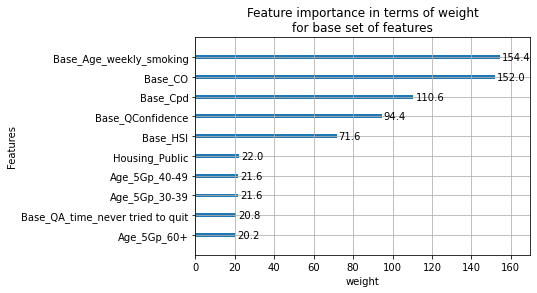

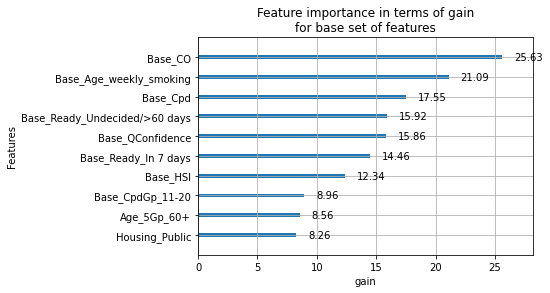

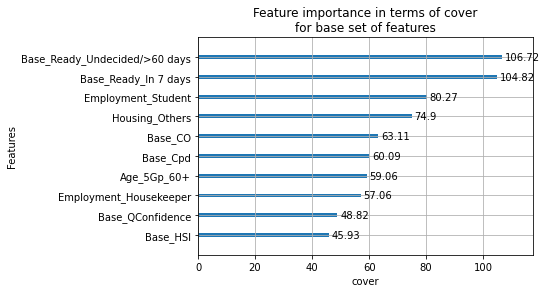

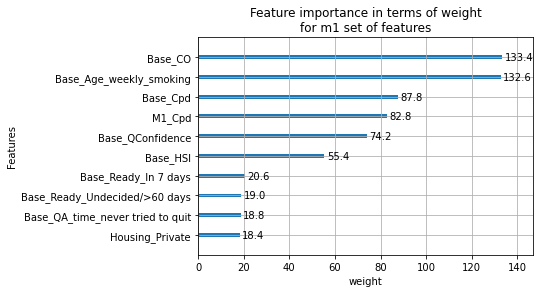

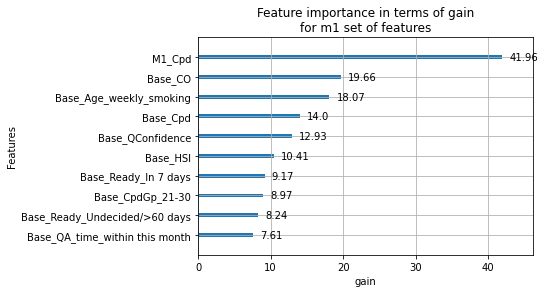

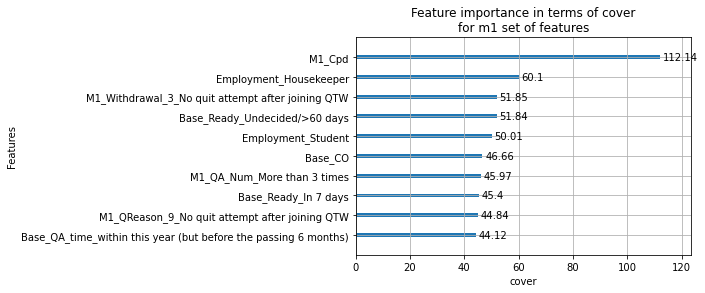

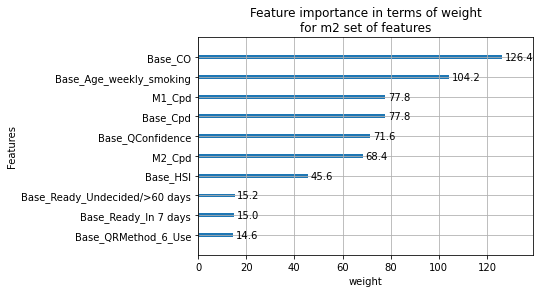

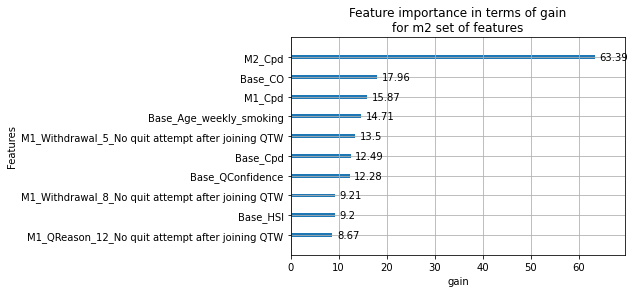

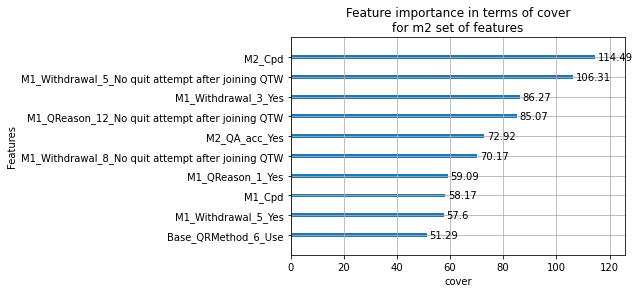

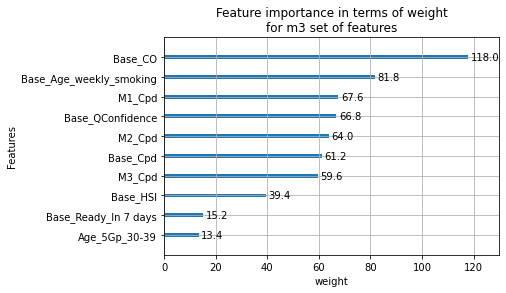

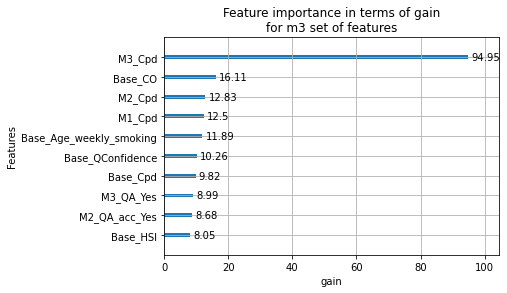

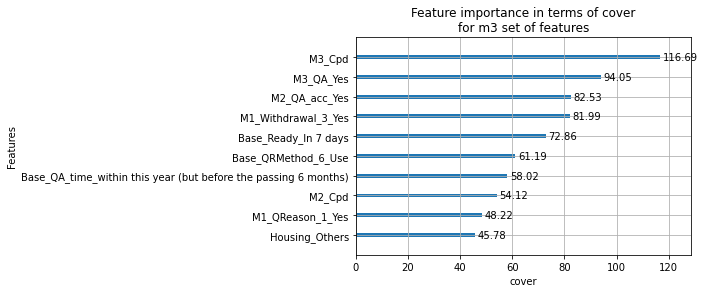

In [37]:

plt.figure(figsize=(20,40))
for name in ['base', 'm1', 'm2', 'm3']:
    importance = {}
    fold_num = 0
    for importance_type in ["weight", 'gain', "cover"]:
        for fold in results[name].keys():
            # Get the importance dictionary (by gain) from the booster
            importance_holder = results[name][fold]["model"].get_score(importance_type=importance_type)
            for key, value in list(zip(importance_holder.keys(), importance_holder.values())):
                if key not in importance.keys():
                    importance[key] = 0
                importance[key] += value
#             import pdb; pdb.set_trace()
            fold_num += 1

        # round off score to 2 decimal places
        for key in importance.keys():
            importance[key] /= fold_num
            importance[key] = round(importance[key],2)
        xgb.plot_importance(importance, 
                            importance_type = importance_type, 
                            max_num_features = 10,
                            xlabel = importance_type,
                            title = f"Feature importance in terms of {importance_type}\nfor {name} set of features")
        plt.savefig(f"./xgboost/feature_importance_{name}_{importance_type}.png", dpi=200, bbox_inches='tight')